# JoJoGAN: One Shot Face Stylization

First, run the cell below to install all the requirements to run JoJoGAN

In [ ]:
!pip install gdown scikit-learn==0.22 scipy lpips dlib opencv-python-headless wandb tensorflow
!wget https://github.com/ninja-build/ninja/releases/download/v1.8.2/ninja-linux.zip
!unzip ninja-linux.zip -d /usr/local/bin/
!update-alternatives --install /usr/bin/ninja ninja /usr/local/bin/ninja 1 --force



In [ ]:
#imports
import torch
torch.backends.cudnn.benchmark = True
from torchvision import transforms, utils
from util import *
from PIL import Image
import math
import random
import os

import numpy as np
from torch import nn, autograd, optim
from torch.nn import functional as F
from tqdm import tqdm
import lpips
from model import *
from e4e_projection import projection as e4e_projection
from copy import deepcopy


os.makedirs('inversion_codes', exist_ok=True)
os.makedirs('style_images', exist_ok=True)
os.makedirs('style_images_aligned', exist_ok=True)
os.makedirs('models', exist_ok=True)

In [ ]:
!gdown https://drive.google.com/uc?id=1s-AS7WRUbL3MzEALxM8y4_XO3n3panxH
!tar -xf pretrained_models.tar.gz
!mv pretrained_models/stylegan2-ffhq-config-f.pt ~/../notebooks
!gdown https://drive.google.com/uc?id=1O8OLrVNOItOJoNGMyQ8G8YRTeTYEfs0P
!mv e4e_ffhq_encode.pt models/

In [ ]:
#Finish setup
device = 'cuda' #@param ['cuda', 'cpu']

latent_dim = 512

# Load original generator
original_generator = Generator(1024, latent_dim, 8, 2).to(device)
ckpt = torch.load('stylegan2-ffhq-config-f.pt')
original_generator.load_state_dict(ckpt["g_ema"], strict=False)
mean_latent = original_generator.mean_latent(10000)

# to be finetuned generator
generator = deepcopy(original_generator)

transform = transforms.Compose(
    [
        transforms.Resize((1024, 1024)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

Loading e4e over the pSp framework from checkpoint: models/e4e_ffhq_encode.pt


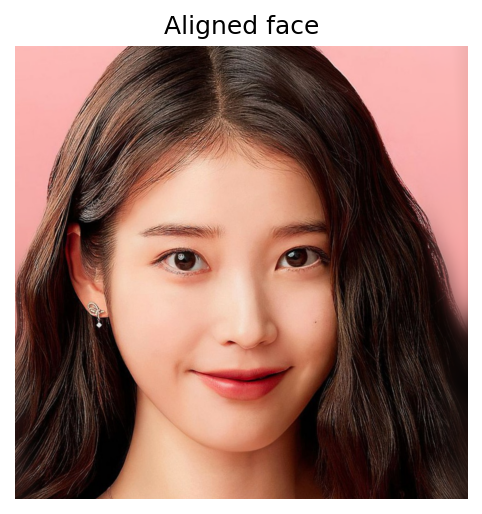

In [ ]:
plt.rcParams['figure.dpi'] = 150

#@title Choose input face
#@markdown Add your own image to the test_input directory and put the name here
filename = 'iu.jpeg' #@param {type:"string"}
filepath = f'test_input/{filename}'

# uploaded = files.upload()
# filepath = list(uploaded.keys())[0]
name = strip_path_extension(filepath)+'.pt'

# aligns and crops face
aligned_face = align_face(filepath)

# my_w = restyle_projection(aligned_face, name, device, n_iters=1).unsqueeze(0)
my_w = e4e_projection(aligned_face, name, device).unsqueeze(0)

display_image(aligned_face, title='Aligned face')
plt.show()

# Use pretrained styles

In [ ]:
!gdown https://drive.google.com/uc?id=15V9s09sgaw-zhKp116VHigf5FowAy43f

# To download more pretrained style models, use the gdown script above with the corresponding id's (the values)
# drive_ids = {
#     "stylegan2-ffhq-config-f.pt": "1Yr7KuD959btpmcKGAUsbAk5rPjX2MytK",
#     "e4e_ffhq_encode.pt": "1o6ijA3PkcewZvwJJ73dJ0fxhndn0nnh7",
#     "restyle_psp_ffhq_encode.pt": "1nbxCIVw9H3YnQsoIPykNEFwWJnHVHlVd",
#     "arcane_caitlyn.pt": "1gOsDTiTPcENiFOrhmkkxJcTURykW1dRc",
#     "arcane_caitlyn_preserve_color.pt": "1cUTyjU-q98P75a8THCaO545RTwpVV-aH",
#     "arcane_jinx_preserve_color.pt": "1jElwHxaYPod5Itdy18izJk49K1nl4ney",
#     "arcane_jinx.pt": "1quQ8vPjYpUiXM4k1_KIwP4EccOefPpG_",
#     "arcane_multi_preserve_color.pt": "1enJgrC08NpWpx2XGBmLt1laimjpGCyfl",
#     "arcane_multi.pt": "15V9s09sgaw-zhKp116VHigf5FowAy43f",
#     "disney.pt": "1zbE2upakFUAx8ximYnLofFwfT8MilqJA",
#     "disney_preserve_color.pt": "1Bnh02DjfvN_Wm8c4JdOiNV4q9J7Z_tsi",
#     "jojo.pt": "13cR2xjIBj8Ga5jMO7gtxzIJj2PDsBYK4",
#     "jojo_preserve_color.pt": "1ZRwYLRytCEKi__eT2Zxv1IlV6BGVQ_K2",
#     "jojo_yasuho.pt": "1grZT3Gz1DLzFoJchAmoj3LoM9ew9ROX_",
#     "jojo_yasuho_preserve_color.pt": "1SKBu1h0iRNyeKBnya_3BBmLr4pkPeg_L",
#     "supergirl.pt": "1L0y9IYgzLNzB-33xTpXpecsKU-t9DpVC",
#     "supergirl_preserve_color.pt": "1VmKGuvThWHym7YuayXxjv0fSn32lfDpE",
#     "art.pt": "1a0QDEHwXQ6hE_FcYEyNMuv5r5UnRQLKT",
# }

In [ ]:
plt.rcParams['figure.dpi'] = 150
pretrained = 'arcane_multi' #@param ['art', 'arcane_multi', 'supergirl', 'arcane_jinx', 'arcane_caitlyn', 'jojo_yasuho', 'jojo', 'disney']
#@markdown Preserve color tries to preserve color of original image by limiting family of allowable transformations. Otherwise, the stylized image will inherit the colors of the reference images, leading to heavier stylizations.
preserve_color = False #@param{type:"boolean"}

ckpt = torch.load('arcane_multi.pt')
generator.load_state_dict(ckpt["g"], strict=False)

#@title Generate results
n_sample =  5#@param {type:"number"}
seed = 3000 #@param {type:"number"}

torch.manual_seed(seed)
with torch.no_grad():
    generator.eval()
    z = torch.randn(n_sample, latent_dim, device=device)

    original_sample = original_generator([z], truncation=0.7, truncation_latent=mean_latent)
    sample = generator([z], truncation=0.7, truncation_latent=mean_latent)

    original_my_sample = original_generator(my_w, input_is_latent=True)
    my_sample = generator(my_w, input_is_latent=True)

# display reference images
if pretrained == 'arcane_multi':
    style_path = f'style_images_aligned/arcane_jinx.png'
else:   
    style_path = f'style_images_aligned/{pretrained}.png'
style_image = transform(Image.open(style_path)).unsqueeze(0).to(device)
face = transform(aligned_face).unsqueeze(0).to(device)

my_output = torch.cat([style_image, face, my_sample], 0)
display_image(utils.make_grid(my_output, normalize=True, range=(-1, 1)), title='My sample')
plt.show()

output = torch.cat([original_sample, sample], 0)
display_image(utils.make_grid(output, normalize=True, range=(-1, 1), nrow=n_sample), title='Random samples')
plt.show()

# Train with your own style images

First, upload the files you want to use to style_images/[your folder name].

Then go into Run_Stylizer.py, and then add the names of your files to the names list. This can also be done using 
```
from os import listdir
from os.path import isfile, join
names = [f for f in listdir([your folder]) if isfile(join([your folder], f))]
```

Be sure add your folder name to line 75 after where it says "style_images/"

You can also adjust the number of iterations to train on line 110.

once you've completed set up, run the cells below to transfer the style to your images. 



In your terminal, enter the following to ensure the Run_Stylizer.py script works
```
cd ../usr/lib/
rm libturbojpeg.a
rm libturbojpeg.la
rm libturbojpeg.so
rm libturbojpeg.so.0
rm libturbojpeg.so.1.0
rm libjpeg.a
rm libjpeg.la
rm libjpeg.so
rm libturbojpeg.so.0     
rm libturbojpeg.so.0.1.0
```


In [ ]:

!python Run_Stylizer.py

In [ ]:
from PIL import Image

image = Image.open('My sample.png')
image.show()
image = Image.open('Random samples.png')
image.show()
image = Image.open('References.png')
image.show()